In [17]:
# ------------------ IMPORTS ------------------
"""
This file contains all the imports that are used in the project.
It is important to mention that it is nessasary to have python 10.3 for ibjpeg.9.dylib on the Mac version M1
"""

import warnings

# Suppress the libjpeg.9.dylib warning from torchvision
#warnings.filterwarnings("ignore", message="Failed to load image Python extension")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from torch.cuda.amp import autocast
from torch.amp import GradScaler
import os

In [18]:
# ------------------------- STEP 1: Data Preparation -------------------------
"""
Data Preparation:
This step prepares the training and test datasets for the Pediatric Chest X-ray Pneumonia classification task.
We define two transformation pipelines: `train_transform` for the training set and `test_transform` for the test set.
The training set includes data augmentation to address class imbalance and improve model generalization, while the test set
only includes necessary preprocessing steps to maintain the true data distribution.

Why Augmentation Before Loading:
Data augmentation is defined before loading the dataset because PyTorch's `ImageFolder` applies transformations on-the-fly
as each image is loaded. This approach is memory-efficient, as it avoids storing multiple augmented images, and ensures
dynamic augmentation (e.g., random flips and rotations) is applied differently in each epoch, increasing the effective variety
of the training data. This is particularly important for addressing the imbalance in our dataset (more pneumonia than normal cases),
as it helps the model see varied samples of the minority class (normal) during training.

Training Transformations:
- Grayscale(num_output_channels=1): Converts the image to single-channel grayscale, as X-rays are inherently grayscale.
- Resize((128, 128)): Resizes the image to 128x128 pixels to reduce computational load and speed up training.
- RandomHorizontalFlip(p=0.5): Flips the image horizontally with a 50% probability, mimicking natural left/right symmetry in X-rays.
- RandomVerticalFlip(p=0.1): Flips the image vertically with a 10% probability, simulating rare orientation variations.
- RandomRotation(15): Rotates the image by a random angle between -15 and +15 degrees, adding variety to patient positioning.
- RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)): Applies small translations (5% shift) and scaling (5% zoom in/out)
  to simulate minor positional variations in X-ray imaging.
- ToTensor(): Converts the image to a PyTorch tensor with shape (1, H, W).
- Normalize(mean=[0.5], std=[0.5]): Normalizes the image to have a mean of 0.5 and standard deviation of 0.5, ensuring consistent input
  values for the model.

Test Transformations:
- Grayscale(num_output_channels=1): Converts the image to single-channel grayscale.
- Resize((128, 128)): Resizes the image to 128x128 pixels for consistency with the training set.
- ToTensor(): Converts the image to a PyTorch tensor.
- Normalize(mean=[0.5], std=[0.5]): Normalizes the image to match the training set’s input distribution.
No augmentation is applied to the test set to preserve the true data distribution for evaluation.
"""

# Define data augmentation for training (reasonable for X-rays, addresses imbalance)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single-channel grayscale
    transforms.Resize((128, 128)),  # Smaller size for speed
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal mirroring
    transforms.RandomVerticalFlip(p=0.1),  # Small chance of vertical flip
    transforms.RandomRotation(15),  # Increased rotation for more variety
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Small translations and scaling
    transforms.ToTensor(),  # Converts to (1, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Test transform (no augmentation, only resizing and normalization)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='../Pediatric Chest X-ray Pneumonia',
    transform=train_transform
)
ext_dataset = datasets.ImageFolder('../additional_validation_xray/Covid19-dataset/Dataset',
transform=test_transform)

# Print dataset statistics to understand the data distribution
print(f"Train Dataset Size: {len(train_dataset)}")
print("Train class distribution:", Counter([label for _, label in train_dataset]))
print("Validation class distribution:", Counter([label for _, label in ext_dataset]))

# Compute class weights to handle the imbalanced dataset
# Class weights are calculated as total_samples / (num_classes * class_count) to give higher weight to the minority class
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
total_samples = len(labels)
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))], dtype=torch.float)
print(f"Class weights (Normal, Pneumonia): {class_weights.tolist()}")

# Compute pos_weight for BCEWithLogitsLoss to further balance the loss function
# pos_weight is the ratio of the weight for the negative class (normal) to the positive class (pneumonia)
pos_weight = torch.tensor([class_weights[0] / class_weights[1]], dtype=torch.float)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight.item()}")

Train Dataset Size: 5856
Train class distribution: Counter({1: 4273, 0: 1583})
Validation class distribution: Counter({0: 90, 1: 90})
Class weights (Normal, Pneumonia): [1.8496525287628174, 0.6852328777313232]
pos_weight for BCEWithLogitsLoss: 2.6993050575256348


In [19]:
"""# ------------------------- STEP 2: Display Samples -------------------------

def display_samples(dataset, num_samples=5):
    normal_count = 0
    pneumonia_count = 0
    class_names = dataset.classes  # ['NORMAL', 'PNEUMONIA']

    plt.figure(figsize=(15, 5))

    for i in range(len(dataset)):
        image, label = dataset[i]
        # Denormalize the image for visualization
        image = image * 0.5 + 0.5  # Reverse normalization to [0, 1]
        image = image.numpy().squeeze()  # Shape: (H, W), single channel

        if label == 0 and normal_count < num_samples:
            plt.subplot(2, num_samples, normal_count + 1)
            plt.imshow(image, cmap='gray')
            plt.title('Normal')
            plt.axis('off')
            normal_count += 1

        elif label == 1 and pneumonia_count < num_samples:
            plt.subplot(2, num_samples, num_samples + pneumonia_count + 1)
            plt.imshow(image, cmap='gray')
            plt.title('Pneumonia')
            plt.axis('off')
            pneumonia_count += 1

        if normal_count >= num_samples and pneumonia_count >= num_samples:
            break

    plt.tight_layout()
    plt.show()

display_samples(train_dataset, num_samples=5)
"""

"# ------------------------- STEP 2: Display Samples -------------------------\n\ndef display_samples(dataset, num_samples=5):\n    normal_count = 0\n    pneumonia_count = 0\n    class_names = dataset.classes  # ['NORMAL', 'PNEUMONIA']\n\n    plt.figure(figsize=(15, 5))\n\n    for i in range(len(dataset)):\n        image, label = dataset[i]\n        # Denormalize the image for visualization\n        image = image * 0.5 + 0.5  # Reverse normalization to [0, 1]\n        image = image.numpy().squeeze()  # Shape: (H, W), single channel\n\n        if label == 0 and normal_count < num_samples:\n            plt.subplot(2, num_samples, normal_count + 1)\n            plt.imshow(image, cmap='gray')\n            plt.title('Normal')\n            plt.axis('off')\n            normal_count += 1\n\n        elif label == 1 and pneumonia_count < num_samples:\n            plt.subplot(2, num_samples, num_samples + pneumonia_count + 1)\n            plt.imshow(image, cmap='gray')\n            plt.title('Pne

In [20]:
# ------------------------- Model Architecture -------------------------
""" 
Model Architecture:
This step defines the model architecture for the Pediatric Chest X-ray Pneumonia classification task.
The model is designed to take single-channel grayscale images of size 128x128 pixels
as input and output a single prediction score for pneumonia (1) or normal (0).

Model Architecture:
- Conv1: 1 input channel, 32 output channels, kernel size 3, padding 1
- Conv2: 32 input channels, 64 output channels, kernel size 3, padding 1
- MaxPool: 2x2 pooling
- FC1: 64 * 32 * 32 input features, 128 output features
- FC2: 128 input features, 1 output feature (prediction score)
- Dropout: 25% dropout rate after the second convolutional layer

The model uses ReLU activation functions after each layer (except the output layer) and a dropout layer to prevent overfitting.

The get_resnet_model function returns a pre-trained ResNet-18 model with the final fully connected layer replaced
to output a single prediction score for pneumonia (1) or normal (0). The model uses the default weights from the
torchvision.models.resnet18 function and freezes all layers except the final fully connected layer to retain the
pre-trained features. The final fully connected layer is replaced with a new layer that outputs a single prediction score."""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class FourLayerCNN(nn.Module):
    def __init__(self):
        super(FourLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        # Calculate the size after 4 pooling layers from 128x128:
        # 128 -> 64 -> 32 -> 16 -> 8, so feature map is 8x8 with 256 channels
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def get_resnet_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

Using device: cpu


In [21]:
# ------------------------- Data Split Function -------------------------

"""We define a function `create_data_loaders` to split the training dataset into train, and test sets.
in our case we have two options for the split type: '60/20/20'.
the validation is made on another dataset that is not used for training. We found this dataset on kaagle. """

def create_data_loaders():
    # 60/20/20 split of the main training dataset
    total_size = len(train_dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

    # DataLoaders
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    # External validation set loader
    external_loader = DataLoader(ext_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, external_loader

In [25]:
# ------------------------- STEP 5: Training and Evaluation Functions -------------------------
def train_model(model, train_loader, val_loader, num_epochs=20, patience=4):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler() if device.type == 'cuda' else None

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            if device.type == 'cuda':
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs).squeeze() > 0.5).int()
            correct += (preds == labels.squeeze().int()).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        
        # ---------- Validation ----------
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    preds = (torch.sigmoid(outputs).squeeze() > 0.5).int()
                    val_correct += (preds == labels.squeeze().int()).sum().item()
                    val_total += labels.size(0)

            val_epoch_loss = val_loss / len(val_loader)
            val_epoch_acc = 100 * val_correct / val_total
            val_losses.append(val_epoch_loss)
            val_accuracies.append(val_epoch_acc)

            print(f"Validation Loss: {val_epoch_loss:.4f} , Val Accuracy: {val_epoch_acc:.2f}%")

            # ---------- Early Stopping ----------
            if val_epoch_loss < best_val_loss:
                best_val_loss = val_epoch_loss
                patience_counter = 0
                # Optional: save best model
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                print(f"EarlyStopping counter: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break
        else:
            val_losses.append(None)
            val_accuracies.append(None)

    return val_losses, val_accuracies, train_losses, train_accuracies


def evaluate_model(model, loader, return_probs=False):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds) * 100,
        'precision': precision_score(all_labels, all_preds) * 100,
        'recall': recall_score(all_labels, all_preds) * 100,
        'f1': f1_score(all_labels, all_preds) * 100
    }

    if return_probs:
        return metrics, all_probs, all_labels, all_preds
    return metrics

def extract_features(model, loader):
    features, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            out = model(images)
            features.append(out.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

def evaluate_classical_model(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]  # Probability for positive class
    preds = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, preds) * 100,
        'precision': precision_score(y_test, preds) * 100,
        'recall': recall_score(y_test, preds) * 100,
        'f1': f1_score(y_test, preds) * 100
    }
    return metrics, probs, y_test, preds

In [26]:
# ------------------------- STEP 6: Plotting Functions -------------------------

def plot_metrics(model_name, split, train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    if val_losses[0] is not None:
        plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title(f'{model_name} - {split} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Acc')
    if val_accuracies[0] is not None:
        plt.plot(epochs, val_accuracies, 'r-', label='Val Acc')
    plt.title(f'{model_name} - {split} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, model_name, split):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Calculate percentages
    total = np.sum(cm)  # Total number of predictions
    cm_percent = (cm / total) * 100  # Convert to percentages
    
    # Plot using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=cm_percent, fmt='.1f', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'Confusion Matrix - {model_name} - {split}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

MODEL: FourLayerCNN
Epoch [1/20], Train Loss: 0.6969, Train Acc: 76.29%
Validation Loss: 0.4379 , Val Accuracy: 84.71%
Epoch [2/20], Train Loss: 0.3804, Train Acc: 89.44%
Validation Loss: 0.3181 , Val Accuracy: 91.63%
Epoch [3/20], Train Loss: 0.3076, Train Acc: 91.43%
Validation Loss: 0.2916 , Val Accuracy: 93.17%
Epoch [4/20], Train Loss: 0.3005, Train Acc: 91.86%
Validation Loss: 0.2849 , Val Accuracy: 91.63%
Epoch [5/20], Train Loss: 0.2656, Train Acc: 92.91%
Validation Loss: 0.2863 , Val Accuracy: 93.60%
EarlyStopping counter: 1/4
Epoch [6/20], Train Loss: 0.2354, Train Acc: 93.42%
Validation Loss: 0.2665 , Val Accuracy: 93.00%
Epoch [7/20], Train Loss: 0.2456, Train Acc: 93.05%
Validation Loss: 0.2779 , Val Accuracy: 93.60%
EarlyStopping counter: 1/4
Epoch [8/20], Train Loss: 0.2405, Train Acc: 93.23%
Validation Loss: 0.2696 , Val Accuracy: 93.68%
EarlyStopping counter: 2/4
Epoch [9/20], Train Loss: 0.2309, Train Acc: 93.91%
Validation Loss: 0.2377 , Val Accuracy: 93.00%
Epoch [1

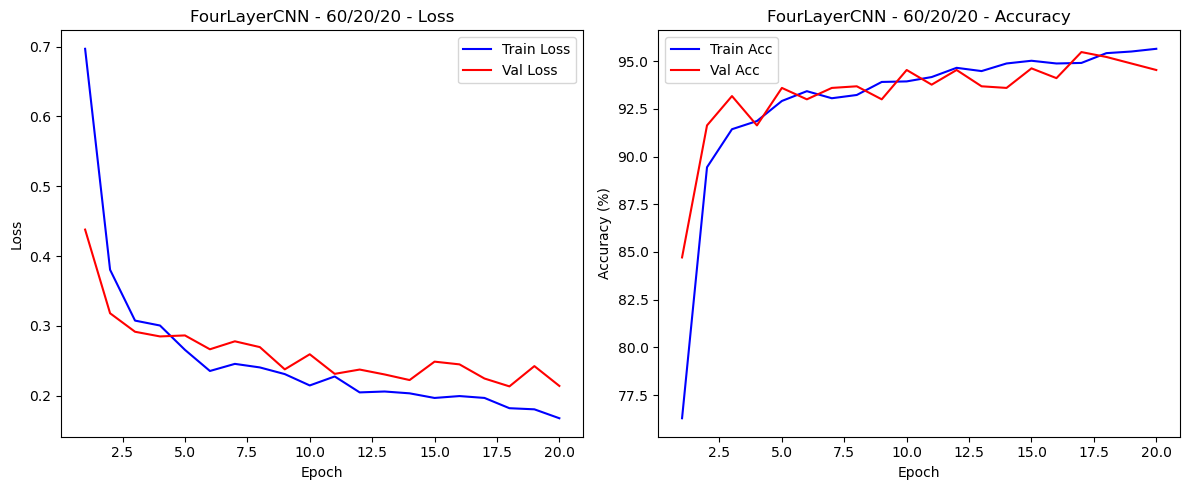

FourLayerCNN model saved to: ../models\fourlayer_cnn_60_20_20.pth
MODEL: ResNet18
Epoch [1/20], Train Loss: 0.7122, Train Acc: 73.90%
Validation Loss: 0.5635 , Val Accuracy: 76.86%
Epoch [2/20], Train Loss: 0.5311, Train Acc: 78.79%
Validation Loss: 0.5027 , Val Accuracy: 81.81%
Epoch [3/20], Train Loss: 0.4961, Train Acc: 82.07%
Validation Loss: 0.4871 , Val Accuracy: 80.10%
Epoch [4/20], Train Loss: 0.4570, Train Acc: 83.32%
Validation Loss: 0.4532 , Val Accuracy: 85.23%
Epoch [5/20], Train Loss: 0.4567, Train Acc: 84.12%
Validation Loss: 0.4518 , Val Accuracy: 83.86%
Epoch [6/20], Train Loss: 0.4430, Train Acc: 83.89%
Validation Loss: 0.4481 , Val Accuracy: 84.63%
Epoch [7/20], Train Loss: 0.4417, Train Acc: 84.66%
Validation Loss: 0.4270 , Val Accuracy: 84.71%
Epoch [8/20], Train Loss: 0.4460, Train Acc: 85.03%
Validation Loss: 0.4478 , Val Accuracy: 82.58%
EarlyStopping counter: 1/4
Epoch [9/20], Train Loss: 0.4456, Train Acc: 84.71%
Validation Loss: 0.4145 , Val Accuracy: 86.17%


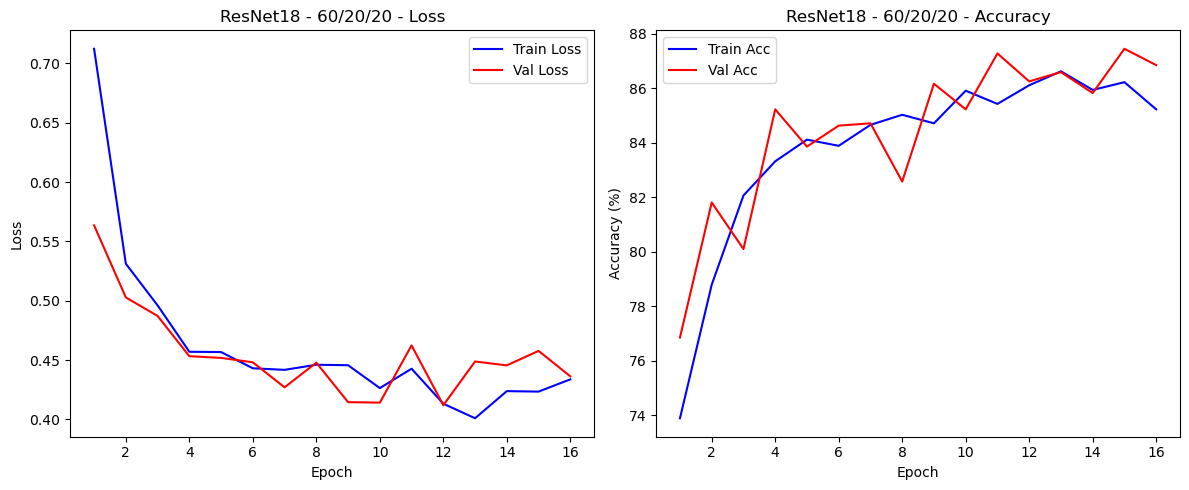

 ResNet18 model saved to: ../models\resnet18_60_20_20.pth

 Evaluation Results Summary:
    accuracy  precision     recall         f1         model     split
0  94.453925  94.004525  98.576512  96.236248  FourLayerCNN  60/20/20
1  91.111111  87.755102  95.555556  91.489362  FourLayerCNN  external
2  87.969283  87.823276  96.678529  92.038396      ResNet18  60/20/20
3  79.444444  87.323944  68.888889  77.018634      ResNet18  external


In [ ]:
# ------------------------- STEP 7: Model Comparison -------------------------

# model weight save 
model_dir = '../models'

results = []

split = '60/20/20'

# Create data loaders
train_loader, val_loader, test_loader, external_loader = create_data_loaders()

# -------------------- FourLayerCNN --------------------
print("MODEL: FourLayerCNN")
cnn_model = FourLayerCNN()
val_losses, val_accuracies, train_losses, train_accuracies = train_model(
    cnn_model, train_loader, val_loader, num_epochs=20, patience=4
)
plot_metrics('FourLayerCNN', split, train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate on test set
cnn_test_metrics, cnn_probs, cnn_labels, cnn_preds = evaluate_model(cnn_model, test_loader, return_probs=True)
cnn_test_metrics.update({'model': 'FourLayerCNN', 'split': split})
results.append(cnn_test_metrics)

# Evaluate on external dataset if applicable
cnn_ext_metrics, cnn_ext_probs, cnn_ext_labels, cnn_ext_preds = evaluate_model(cnn_model, external_loader, return_probs=True)
cnn_ext_metrics.update({'model': 'FourLayerCNN', 'split': 'external'})
results.append(cnn_ext_metrics)

# Save model
cnn_model_path = os.path.join(model_dir, f'fourlayer_cnn_{split.replace("/", "_")}.pth')
torch.save(cnn_model.state_dict(), cnn_model_path)
print(f"FourLayerCNN model saved to: {cnn_model_path}")

# -------------------- ResNet18 --------------------
print("MODEL: ResNet18")
resnet_model = get_resnet_model()
val_losses, val_accuracies, train_losses, train_accuracies = train_model(
    resnet_model, train_loader, val_loader, num_epochs=20, patience=4
)
plot_metrics('ResNet18', split, train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate on test set
resnet_test_metrics, resnet_probs, resnet_labels, resnet_preds = evaluate_model(resnet_model, test_loader, return_probs=True)
resnet_test_metrics.update({'model': 'ResNet18', 'split': split})
results.append(resnet_test_metrics)

# Evaluate on external dataset 
resnet_ext_metrics, resnet_ext_probs, resnet_ext_labels, resnet_ext_preds = evaluate_model(resnet_model, external_loader, return_probs=True)
resnet_ext_metrics.update({'model': 'ResNet18', 'split': 'external'})
results.append(resnet_ext_metrics)

# Save model
resnet_model_path = os.path.join(model_dir, f'resnet18_{split.replace("/", "_")}.pth')
torch.save(resnet_model.state_dict(), resnet_model_path)
print(f" ResNet18 model saved to: {resnet_model_path}")

# -------------------- Display Results --------------------
df_results = pd.DataFrame(results)
print("\n Evaluation Results Summary:")
print(df_results)


In [28]:
print("Train class distribution (60%):", Counter([train_dataset[i][1] for i in train_loader.dataset.indices]))
print("Val (internal) class distribution (20%):", Counter([train_dataset[i][1] for i in val_loader.dataset.indices]))
print("Test class distribution (20%):", Counter([train_dataset[i][1] for i in test_loader.dataset.indices]))

Train class distribution (60%): Counter({1: 2568, 0: 945})
Val (internal) class distribution (20%): Counter({1: 862, 0: 309})
Test class distribution (20%): Counter({1: 843, 0: 329})


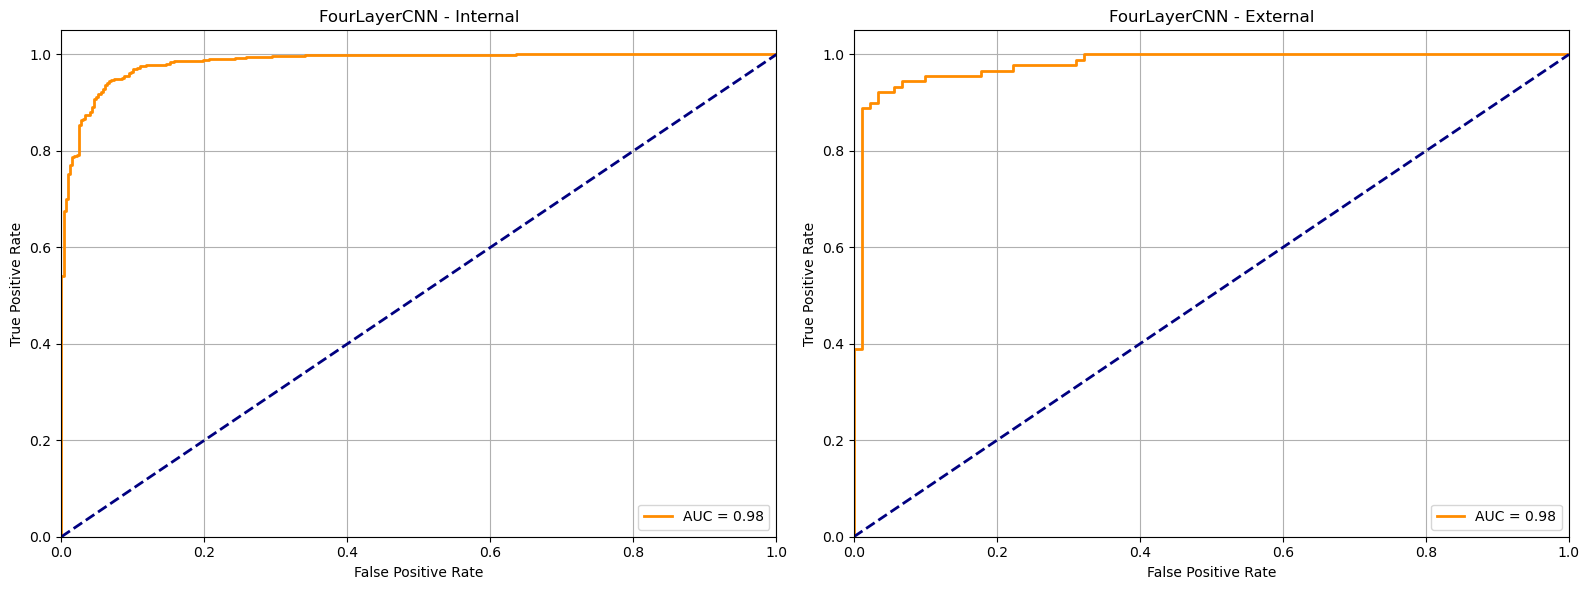

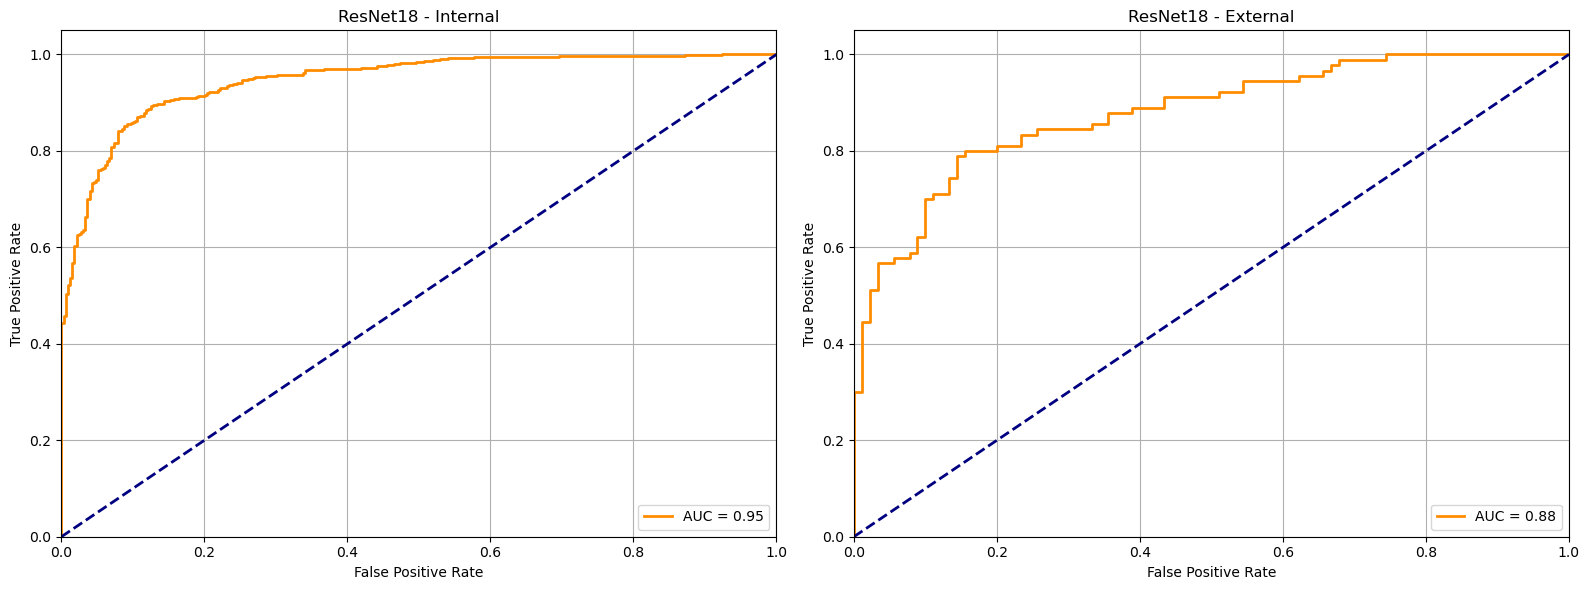

In [29]:
# ------------------------- ROC Comparison -------------------------   
"""Displaying ROC Curves of FourLayerCNN and ResNet18 side-by-side (Internal vs. External)"""

# ---- FourLayerCNN ROC side-by-side ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Internal
fpr, tpr, _ = roc_curve(cnn_labels, cnn_probs)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_title('FourLayerCNN - Internal')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid()

# External
fpr, tpr, _ = roc_curve(cnn_ext_labels, cnn_ext_probs)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_title('FourLayerCNN - External')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()


# ---- ResNet18 ROC side-by-side ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Internal
fpr, tpr, _ = roc_curve(resnet_labels, resnet_probs)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_title('ResNet18 - Internal')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid()

# External
fpr, tpr, _ = roc_curve(resnet_ext_labels, resnet_ext_probs)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_title('ResNet18 - External')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()


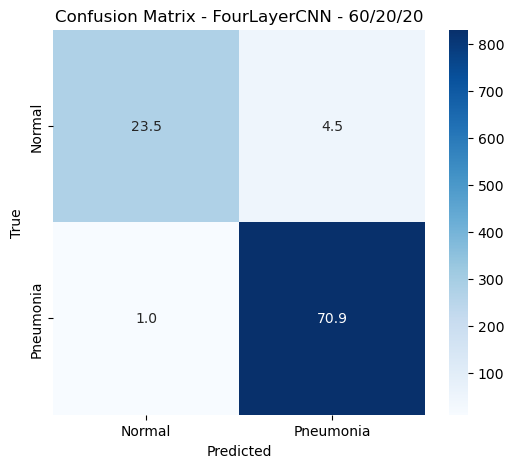

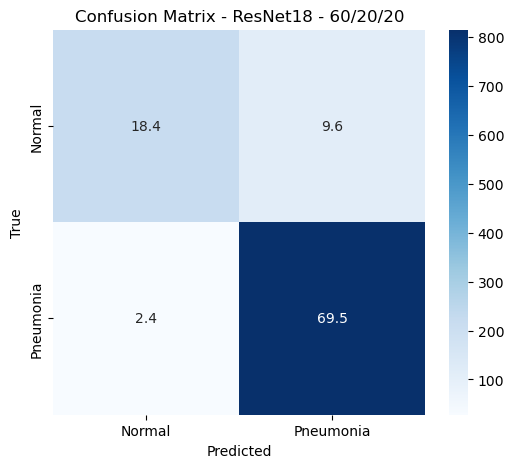

In [31]:
# ------------------------- Confusion Matrix -------------------------
# Plot Confusion Matrix for FourLayerCNN
plot_confusion_matrix(cnn_labels, cnn_preds, 'FourLayerCNN', split)
# Plot Confusion Matrix for ResNet18
plot_confusion_matrix(resnet_labels, resnet_preds, 'ResNet18', split)


Results Table:
    accuracy  precision     recall         f1         model     split
0  94.453925  94.004525  98.576512  96.236248  FourLayerCNN  60/20/20
1  91.111111  87.755102  95.555556  91.489362  FourLayerCNN  external
2  87.969283  87.823276  96.678529  92.038396      ResNet18  60/20/20
3  79.444444  87.323944  68.888889  77.018634      ResNet18  external


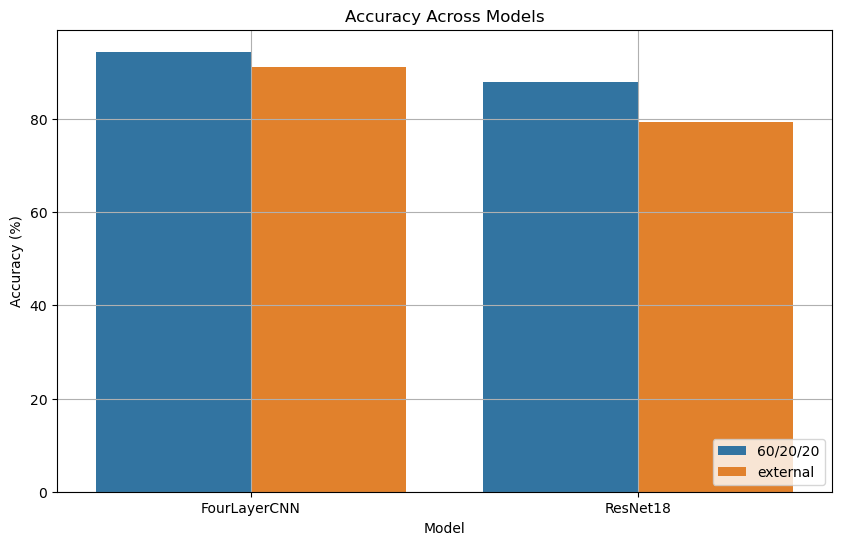

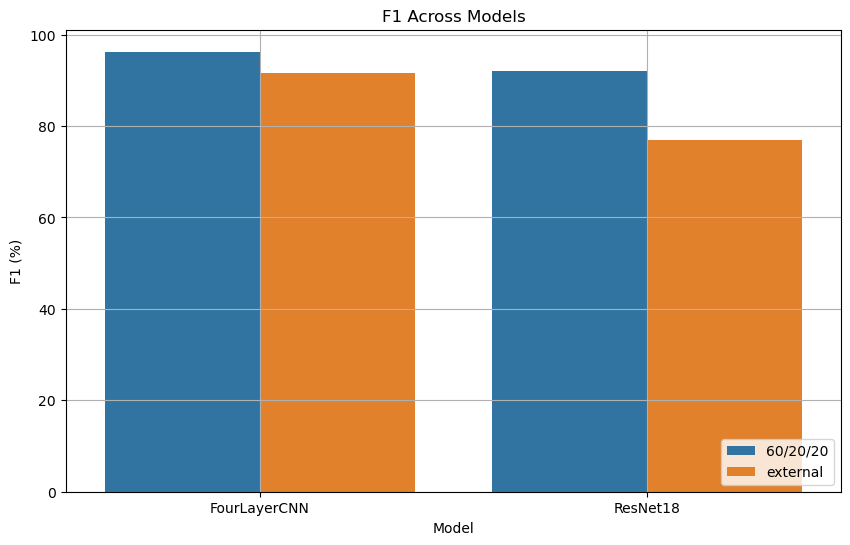

In [33]:
# ------------------------- STEP 8: Results Comparison -------------------------

# Display results table
df_results = pd.DataFrame(results)
print("\nResults Table:")
print(df_results)

# Plot results for comparison
def plot_results(df, metric='accuracy'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model', y=metric, hue='split', data=df)
    plt.title(f'{metric.capitalize()} Across Models')
    plt.ylabel(f'{metric.capitalize()} (%)')
    plt.xlabel('Model')
    plt.grid()
    plt.legend(loc='lower right')  # Move legend to bottom-right corner
    plt.show()

plot_results(df_results, 'accuracy')
plot_results(df_results, 'f1')

In [ ]:
# ------------------------- Classification Report -------------------------
# Für FourLayerCNN:
print("Classification Report – FourLayerCNN:")
print(classification_report(cnn_labels, cnn_preds, target_names=["Normal", "Pneumonia"]))
 
# Für ResNet18:
print("Classification Report – ResNet18:")
print(classification_report(resnet_labels, resnet_preds, target_names=["Normal", "Pneumonia"]))